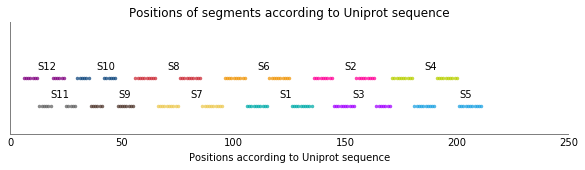

1891 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.



/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [3]:
import itertools
import sys
%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks04'
image_counter = Counter()
from IPython.html.widgets.widget_float import FloatProgress

## Epistasis calculated for every genotype based on fitness of single mutants

#### Different segments

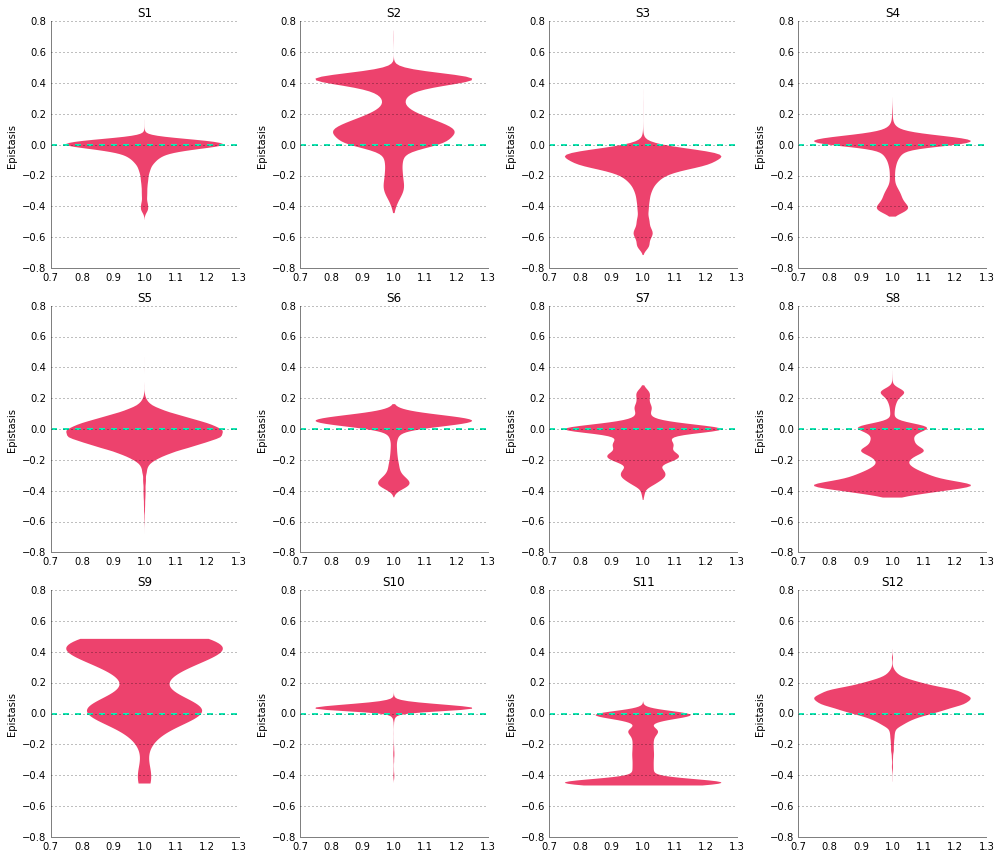

In [93]:
plot_better(width=14, height=12)
title = 'Distribution of epistasis in different segments'
facecolor = '#E91348'
edgecolor = 'none'
zero_color = '#13e9b4'
for index, item in enumerate(data_known_mutations_only.items()):
    segment_name, segment = item
    ax = plt.subplot(3,4,index+1)
    plt.title(segment_name.split('_')[0])
    vplot = plt.violinplot(segment.epistasis.values, showmeans=False, showmedians=False, showextrema=False)
    for patch in vplot['bodies']:
        patch.set_facecolor(facecolor)
        patch.set_alpha(0.8)
        patch.set_edgecolor(edgecolor)
    plt.axhline(0., ls='--', color=zero_color, lw=2)
    improve_plot(ax, grid='y')
    plt.ylabel('Epistasis')
    plt.ylim(-0.8, 0.8)
# plt.suptitle(title, fontsize=18)
plt.tight_layout()
save_image(image_counter, title, figures_folder, notebook_prefix)

In [94]:
# create a dictionary here!
singles_summary = OrderedDict()

for segment_name, segment_data in data_known_mutations_only.items():
    title = 'Epistasis plots for every single mutation segment %s' %segment_name.split('_')[0]
    single_mutations = sorted(list(set(':'.join(segment_data.mut_list_Scer.values).split(':'))))
    total_subplots = len(single_mutations)
    number_of_rows = total_subplots/4+1
    plot_better(width=14, height=4*number_of_rows)
    for index, mutation in enumerate(single_mutations):
        genotypes_with_current_mutation = segment_data[segment_data.mut_list_Scer.str.contains(mutation)] #buggy!
        singles_summary[mutation] = {'fitness': single_mut_fitness_dict[mutation]}
        ax = plt.subplot(number_of_rows,4,index+1)
        plt.title('%s genotypes\ncontaining mutation %s\n(fitness of single mutant: %.2f)' 
                  %(len(genotypes_with_current_mutation), mutation, single_mut_fitness_dict[mutation]))
        vplot = plt.violinplot(genotypes_with_current_mutation.epistasis.values, showmeans=False, showmedians=False, showextrema=False)
        for patch in vplot['bodies']:
            patch.set_facecolor(facecolor)
            patch.set_alpha(0.8)
            patch.set_edgecolor(edgecolor)
        plt.axhline(single_mut_fitness_dict[mutation], ls='--', color='#ffd700', lw=3)
        improve_plot(ax, grid='y')
        plt.ylabel('Epistasis')
        plt.ylim(-0.8, 0.8)
    plt.tight_layout()
    save_image(image_counter, title, figures_folder, notebook_prefix)
    plt.close()

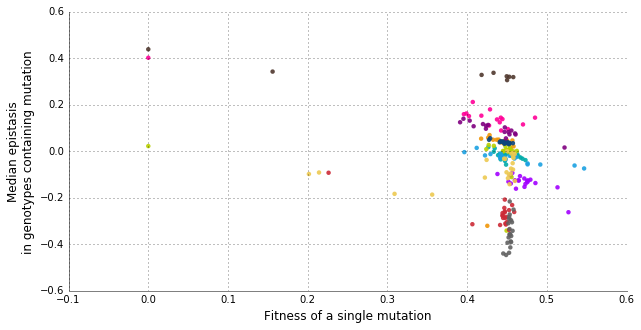

In [98]:
title = 'Fitness of a single mutation vs epistasis'
plot_better()
for single_fitnesses, median_epistasis, segment_name in single_fitness_vs_epistasis:
    plt.scatter(single_fitnesses, median_epistasis, 
                edgecolors='none', alpha=0.9, color=segment_colors[segment_name.split('_')[0]])
plt.xlabel('Fitness of a single mutation', fontsize=12)
plt.ylabel('Median epistasis\nin genotypes containing mutation', fontsize=12)
# plt.xlim(0.38,0.5)
save_image(image_counter, title, figures_folder, notebook_prefix)

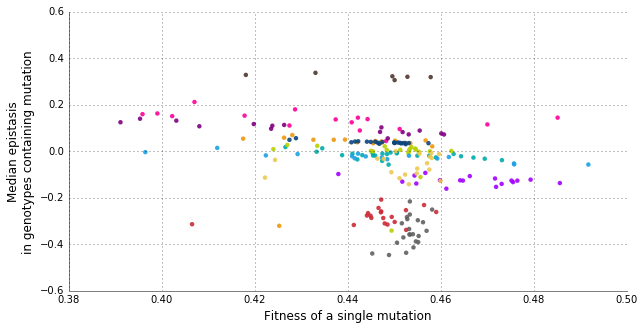

In [96]:
title = 'Fitness of a single mutation vs epistasis'
plot_better()
for single_fitnesses, median_epistasis, segment_name in single_fitness_vs_epistasis:
    plt.scatter(single_fitnesses, median_epistasis, 
                edgecolors='none', alpha=0.9, color=segment_colors[segment_name.split('_')[0]])
plt.xlabel('Fitness of a single mutation', fontsize=12)
plt.ylabel('Median epistasis\nin genotypes containing mutation', fontsize=12)
plt.xlim(0.38,0.5)
save_image(image_counter, title, figures_folder, notebook_prefix)

## Epistasis calculated every pair of mutations based on foursomes wt >mutA, mutB > mutAB

#### Calculating foursomes and saving them as files

In [10]:
foursome_directory = check_dir('foursomes_full_lib/') # requires much space so storing locally

for segment in data:
    # preparing the dataset
    data_subset = data[segment].copy() # full lib!
    data_subset['mut_list_Scer'].fillna('', inplace=True)
    data_subset['wt'] = data_subset['mut_list_Scer']

    # preparing the list of combinations of mutations
    single_mutations = sorted(list(unique_single_mutations[segment]), key= lambda m: (int(m[:-1]), m[-1]))
    mut_combinations = [pair for pair in list(itertools.combinations(single_mutations, 2)) if pair[0][:-1] != pair[1][:-1]]

    print 'Calculating segment %s...' %segment
    print len(mut_combinations), 'combinations of single mutations'

    prefix = 'segment%s__' % segment.split('_')[0]
    get_foursomes_for_every_pair(data_subset, mut_combinations, prefix, foursome_directory)

    print 'Segment %s is done\n' % segment

foursomes_full_lib/
Calculating segment S1_scaled...
21868 combinations of single mutations


KeyboardInterrupt: 

#### Reading foursomes from files, calculating epistasis and other parameters

In [16]:
ep_dict = {}
directory = '/Users/karen/Downloads/foursomes/'
for f in os.listdir(directory):
    if '.hdf' in f:
        mutA, mutB = f.rstrip('.hdf').split('_')[-3], f.rstrip('.hdf').split('_')[-1]
        if mutA in unique_single_mutations['S1_scaled'] and mutB in unique_single_mutations['S1_scaled']:
            foursome = pd.read_hdf(directory + f, 'data')
            ep = foursome['wild_type']['mut_list_Scer'].apply(lambda wt: foursome_epistasis(foursome, wt))
            mutA_impacts = foursome['mutA']['s'] - foursome['wild_type']['s']
            mutB_impacts = foursome['mutB']['s'] - foursome['wild_type']['s']
            mutAB_impacts = foursome['mutAB']['s'] - foursome['wild_type']['s']
            ep_dict[mutA, mutB] = foursome, ep, mutA_impacts, mutB_impacts, mutAB_impacts

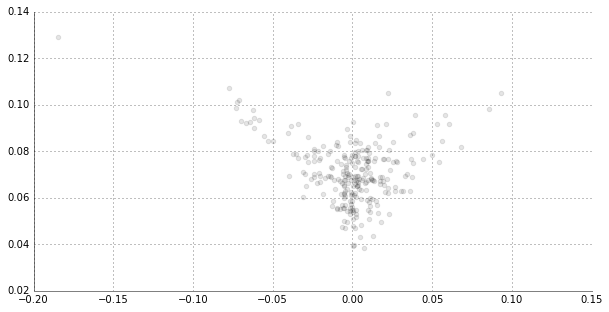

In [67]:
plot_better()
std = OrderedDict()
skew = OrderedDict()
for mutA, mutB in ep_dict:
    ep = ep_dict[mutA, mutB][1]
    if len(ep) > 10:
        std[mutA, mutB] = ep.std()
        skew[mutA, mutB] = ep.skew()
        plt.scatter(ep.mean(), ep.std(), color='black', alpha=0.1)

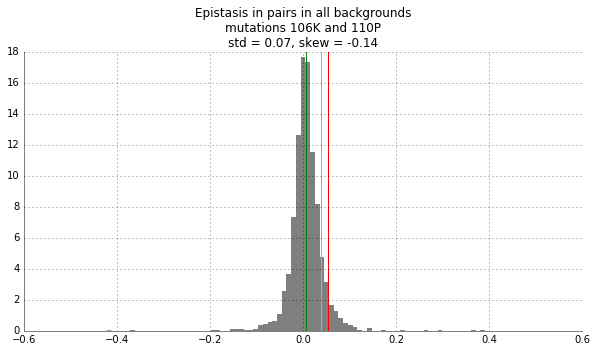

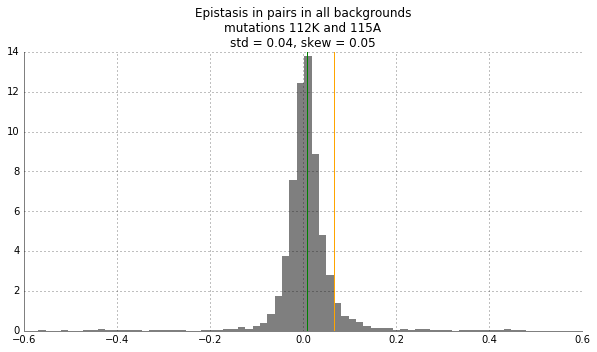

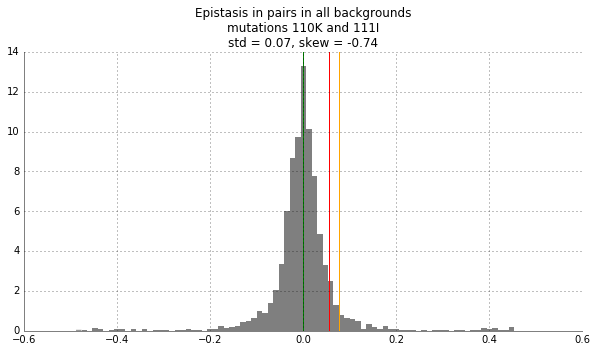

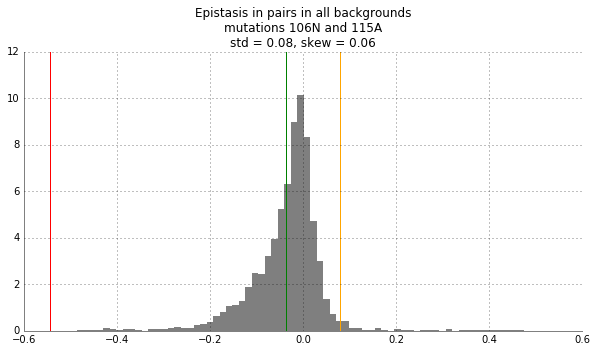

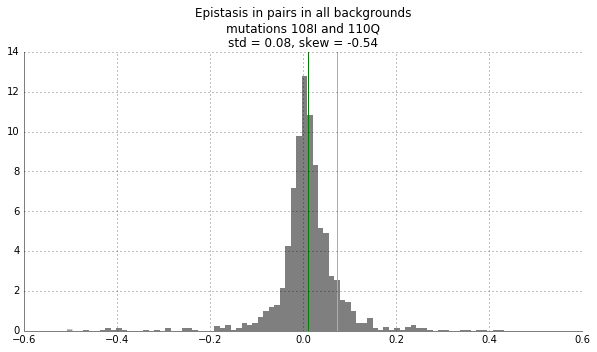

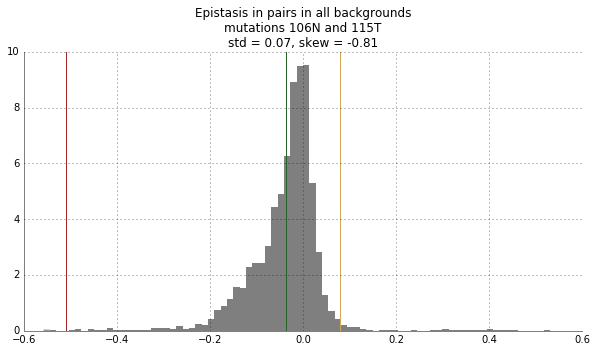

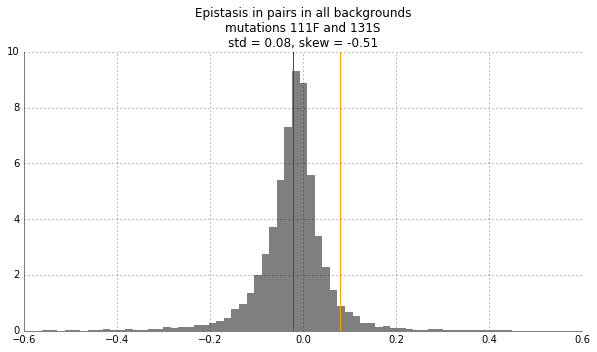

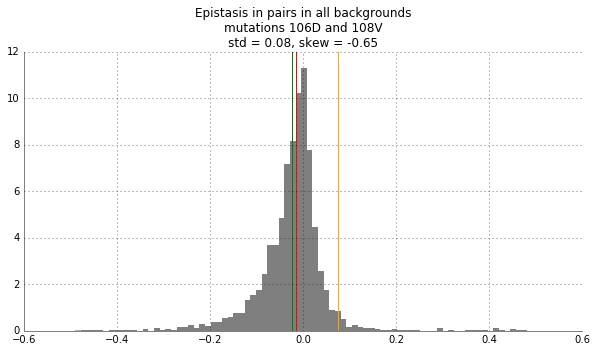

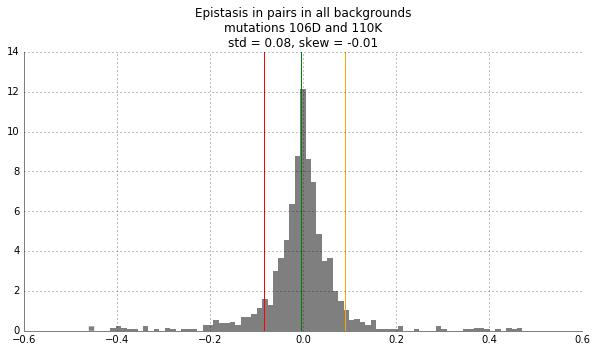

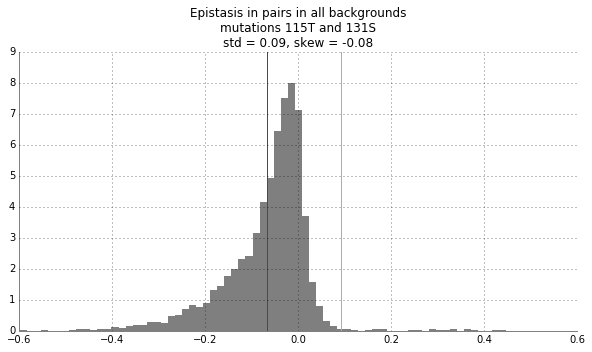

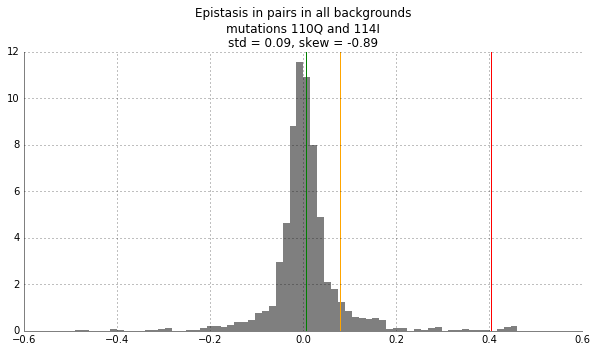

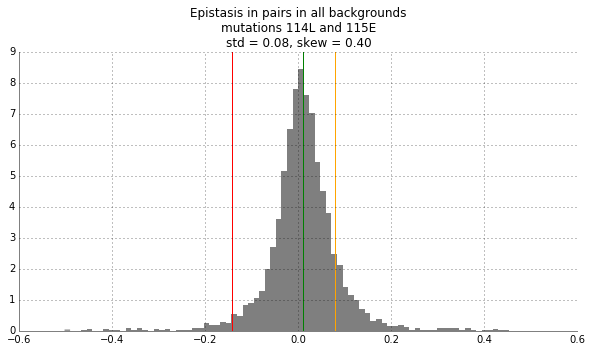

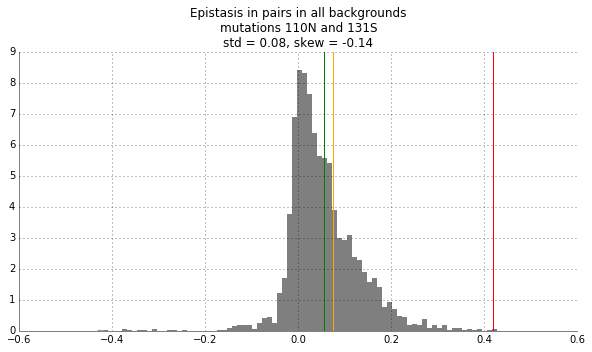

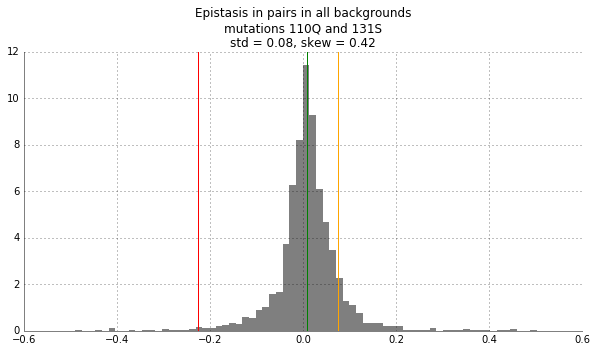

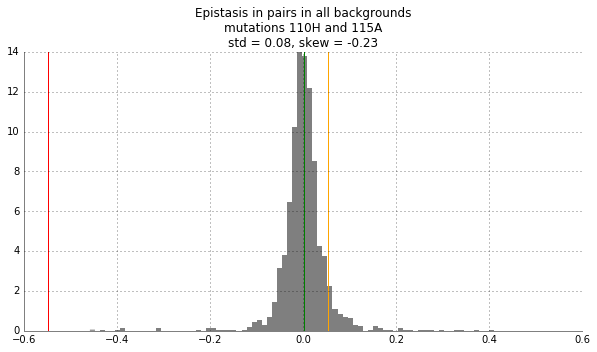

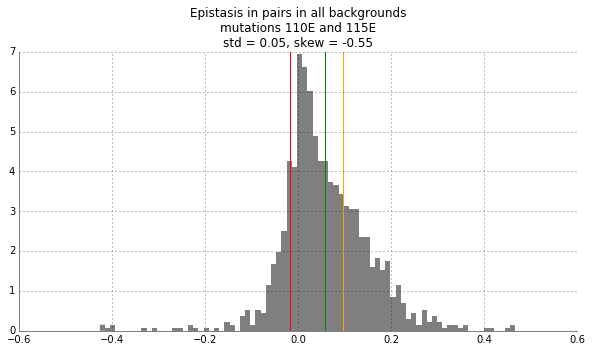

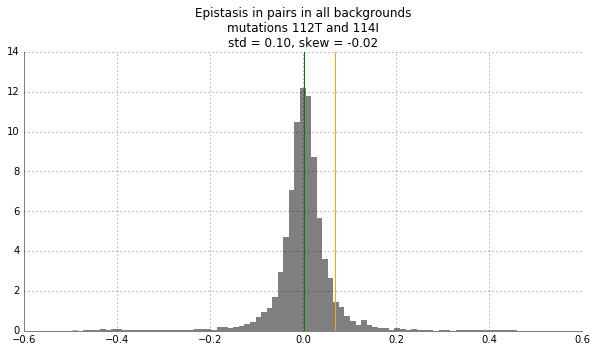

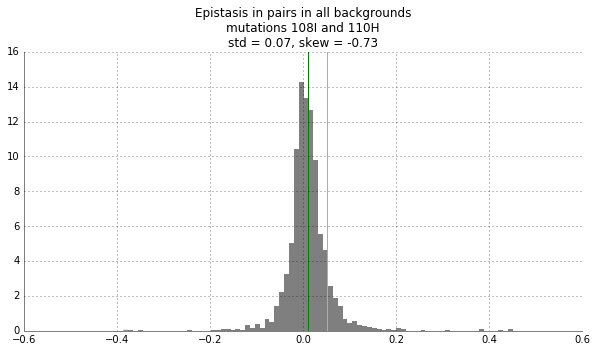

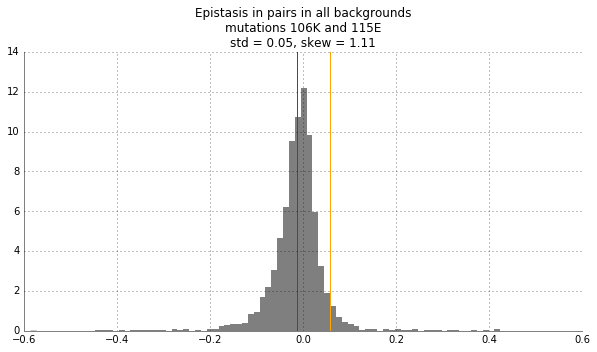

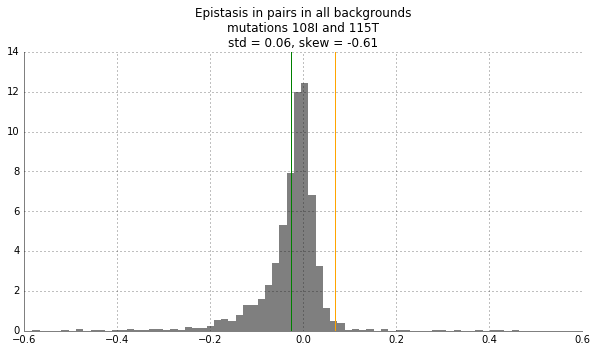

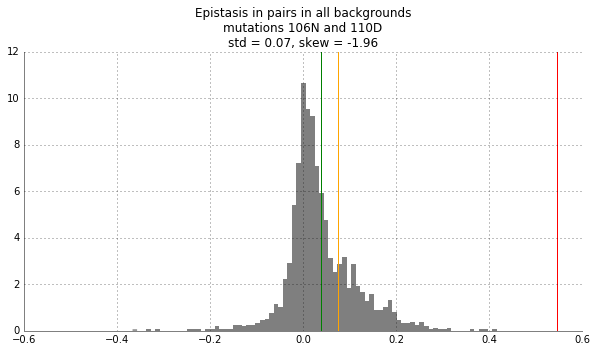

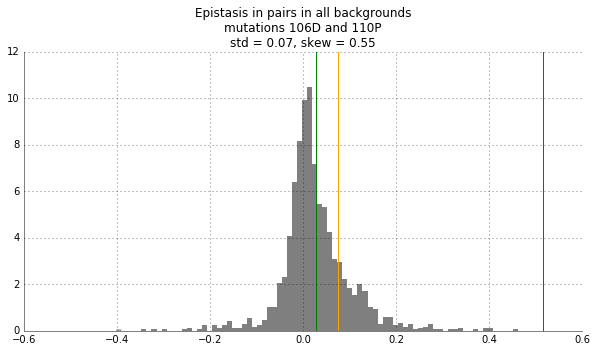

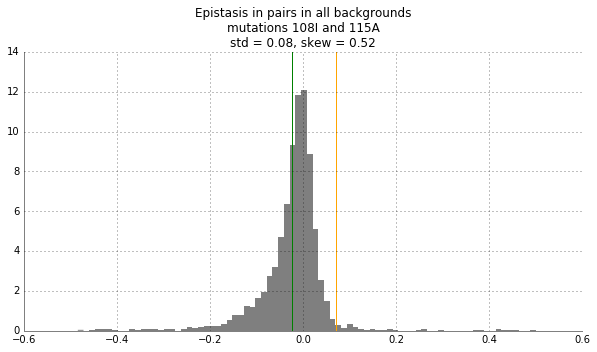

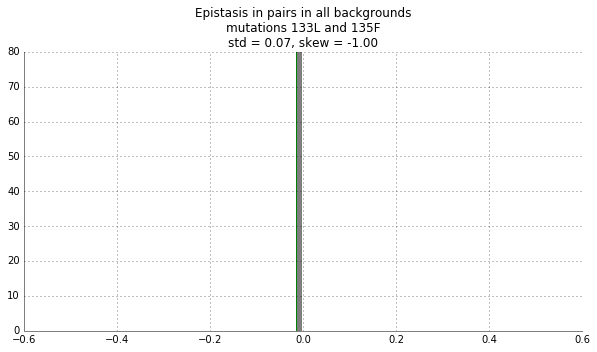

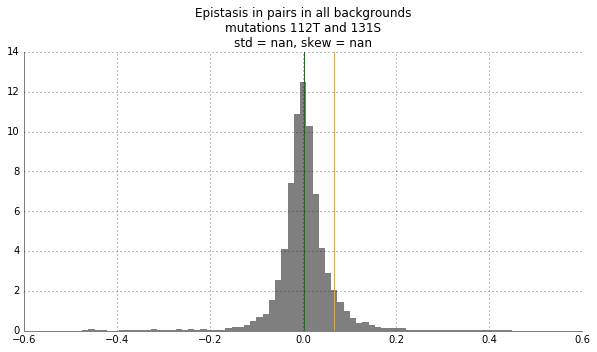

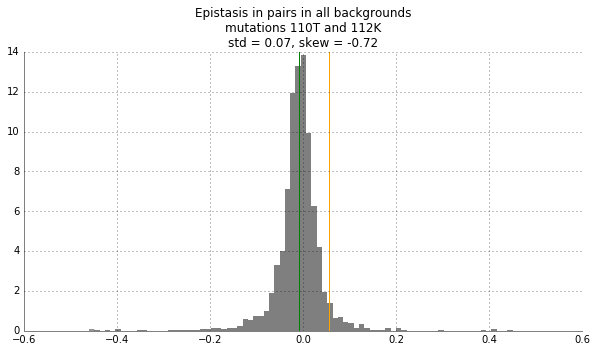

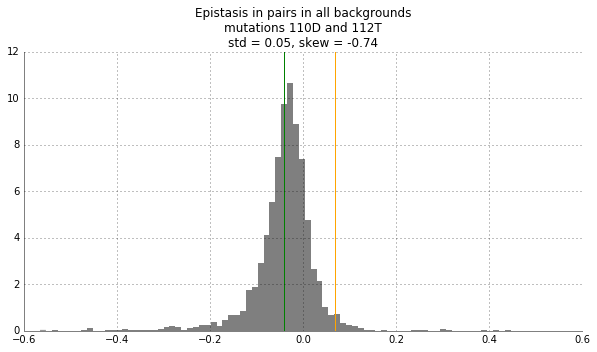

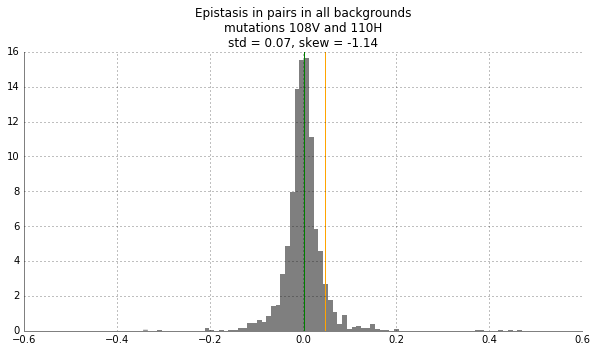

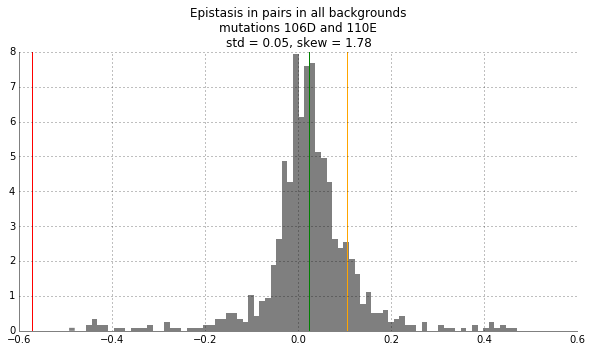

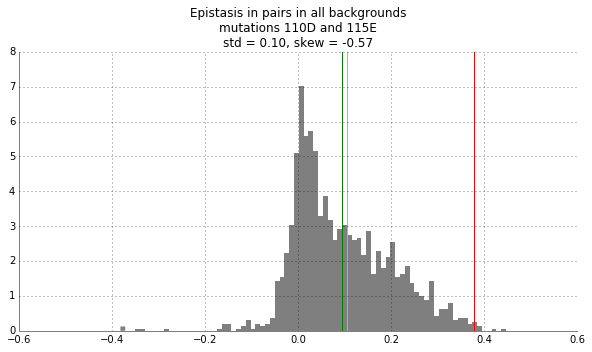

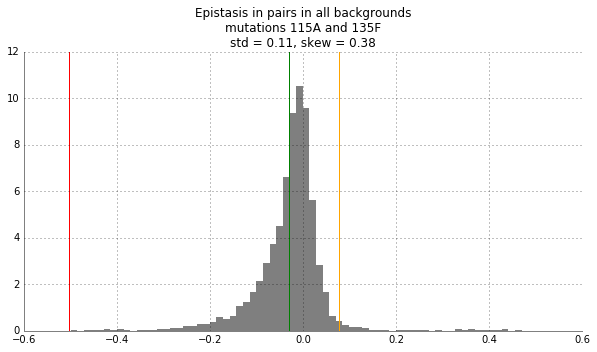

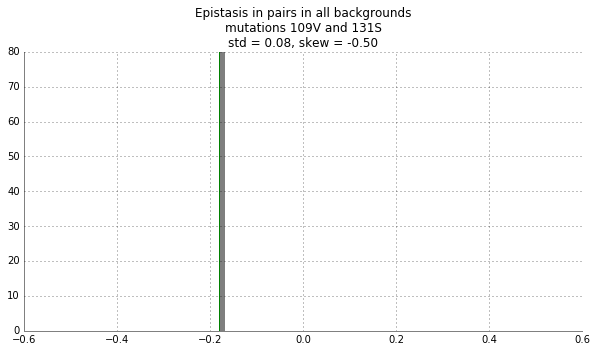

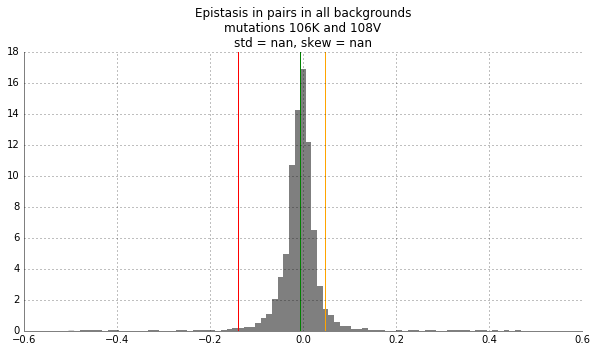

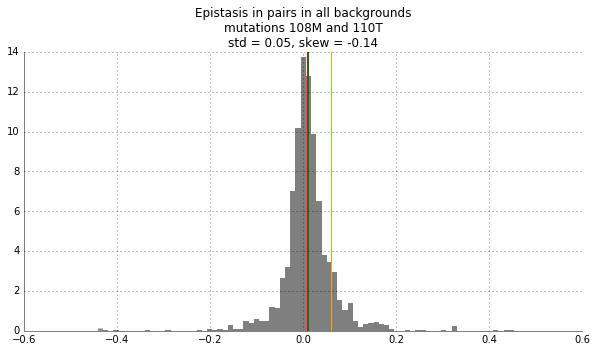

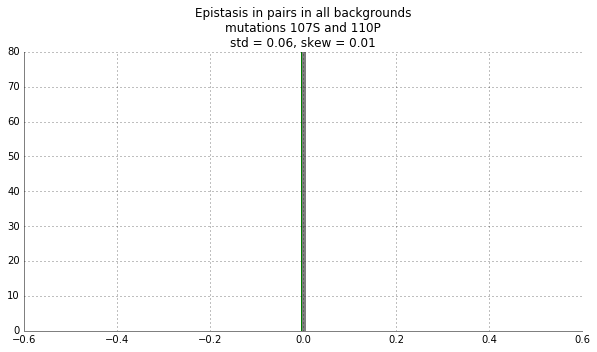

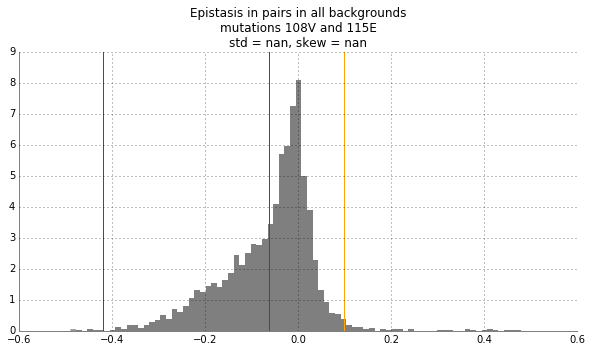

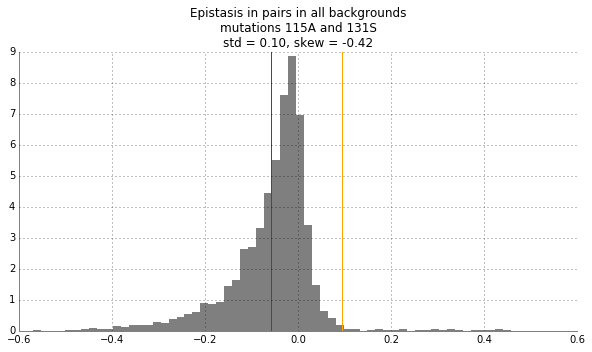

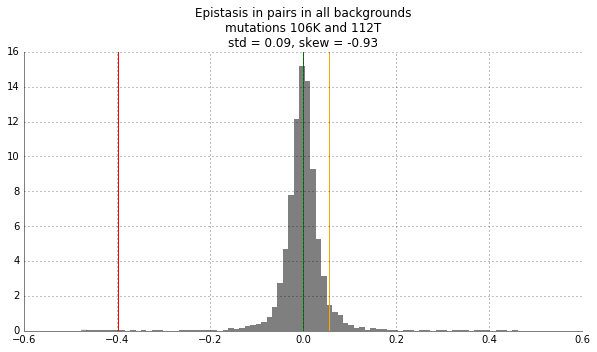

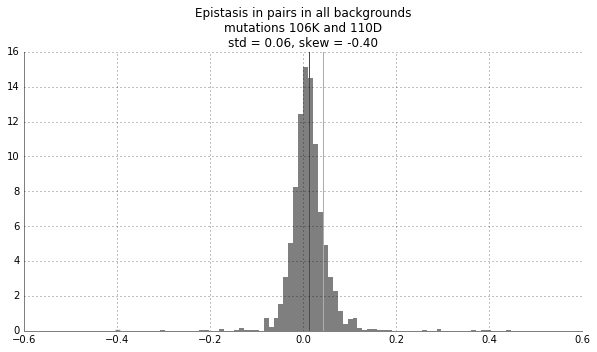

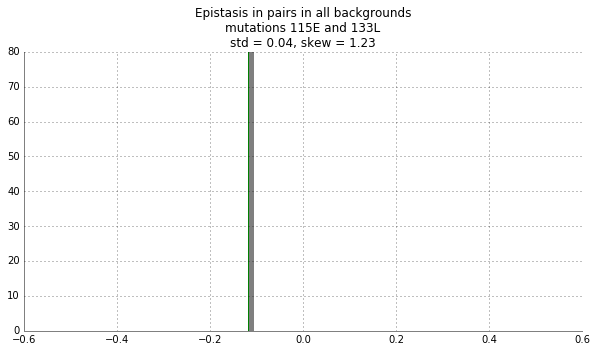

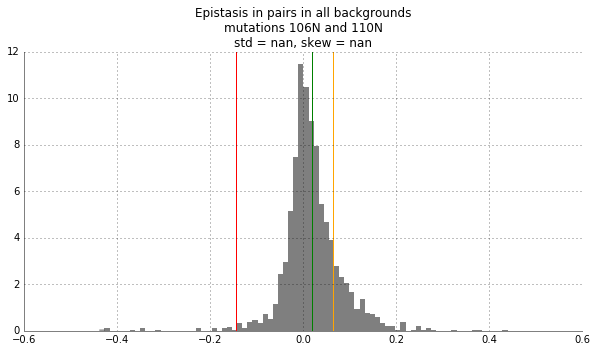

In [65]:
from scipy.stats import norm
counter = 0

for mutA, mutB in ep_dict:
    plot_better()
    title = 'Epistasis in pairs in all backgrounds\nmutations %s and %s' %(mutA, mutB)
    title += '\nstd = %.2f, skew = %.2f' %(ep.std(), ep.skew())
    ep = ep_dict[mutA, mutB][1]
    counter += 1
    plt.title(title)
    plt.hist(ep, edgecolor='none', bins=80, color='black', alpha=0.5, normed=True);
    plt.axvline(ep.std(), color='orange')
    plt.axvline(ep.mean(), color='green')
    plt.axvline(ep.skew(), color='red')
    plt.xlim(-0.6, 0.6)
    
    if counter > 40:
        break

#### Plotting

In [57]:
alpha = 0.4
wt_color = 'magenta'
mutA_color = 'green'
mutB_color = 'orange'

foursomes_folder = os.path.join(figures_folder, 'foursomes_nat')
for k,v in ep_dict.items():
    foursome, ep, mutA_impacts, mutB_impacts  = v
    plot_better()
    plt.scatter(foursome['wild_type']['s'].values, ep.values, edgecolor='none', color='black', alpha=0.05);
    title = 'Epistasis in foursomes with mutations %s and %s' %(k[0], k[1])
    plt.title(title + '\nN = %s' %len(foursome['wild_type']))
    plt.axvline(wt_fitness, color=wt_color, alpha=alpha)
    plt.text(0.52, 0.42, 'wild type', color=wt_color, alpha=alpha)
    plt.axhline(0, color='gray', alpha=0.4)
    
    plt.axvline(wt_fitness + mutA_impacts.median(), color=mutA_color, ls='-', alpha=alpha)
    plt.axvline(wt_fitness + mutB_impacts.median(), color=mutB_color, ls='-', alpha=alpha)

    try:
#         plt.axvline(single_mut_fitness_dict[k[0]], color=mutA_color, alpha=alpha)
#         plt.axvline(single_mut_fitness_dict[k[1]], color=mutB_color, alpha=alpha)
        plt.text(0.52, 0.52, 'median impact of %s' % k[0], color=mutA_color, alpha=alpha)
        plt.text(0.52, 0.47, 'median impact of %s' % k[1], color=mutB_color, alpha=alpha)
    except:
        pass
    plt.xlim(0, 0.6)
    plt.ylim(-0.6, 0.6)
    plt.xlabel('Fitness of a "wild type" combination')
    plt.ylabel('Epistasis in a foursome')
    save_image(image_counter, title, foursomes_folder, notebook_prefix)
    plt.close()

In [ ]:
plot_better()
for k,v in ep_dict.items():
    mutA, mutB = k
    foursome, ep, mutA_impacts, mutB_impacts  = v
    try:
        plt.scatter(single_mut_fitness_dict[mutA], mutA_impacts.median(), edgecolor='none', alpha=0.1)
        plt.scatter(single_mut_fitness_dict[mutB], mutB_impacts.median(), edgecolor='none', alpha=0.1)
    except KeyError:
        pass